In [34]:
# import pyarrow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from utils.helper_functions import StockDataset # custom dataset class
import torch.nn.functional as F

## Organize data
- train and test data
- input sequence size </= length of days in
- treat NANs as zero values or normalize to 0-1 and treat NANs as -1
- Data loaders

TODO: decide how to split train/test (not shuffled split right?)

TODO: Tinker with DataLoader has drop_last = True which removes the last incomplete batch; may need to change this to False later

In [35]:
# Number of days in the input sequence
day_range = 90 # How many days in a sequence; day_range - days_in = number of days to predict

# Number of days the MLP will take as input
days_in = 89 # how many days the MLP will take as input

# Ensure that the total number of days in the input sequence is larger than the MLP input size
assert day_range > days_in, "The total day range must be larger than the input days for the LSTM"

### Subset dataframe into columns that have highest correlation with responder 6

In [36]:
# Dataset
split_ratio = 0.8
parquet_file = 'data/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet'
subset_n = 10

# correlation test for which columns to keep
df = pd.read_parquet(parquet_file, engine="pyarrow")

# Load the dataset
train_data = StockDataset(parquet_file=parquet_file, day_range=day_range, split_ratio=split_ratio, train_test="train", subset = True, subset_n=subset_n)
test_data = StockDataset(parquet_file=parquet_file, day_range=day_range, split_ratio=split_ratio, train_test="test", subset = True, subset_n=subset_n)

100%|██████████| 91/91 [00:02<00:00, 43.38it/s]


In [37]:
print(len(train_data.dataset.columns))
print(train_data.dataset.columns)

13
Index(['seq_id', 'symbol_id', 'weight', 'feature_06', 'feature_07',
       'responder_0', 'responder_2', 'responder_3', 'responder_4',
       'responder_5', 'responder_6', 'responder_7', 'responder_8'],
      dtype='object')


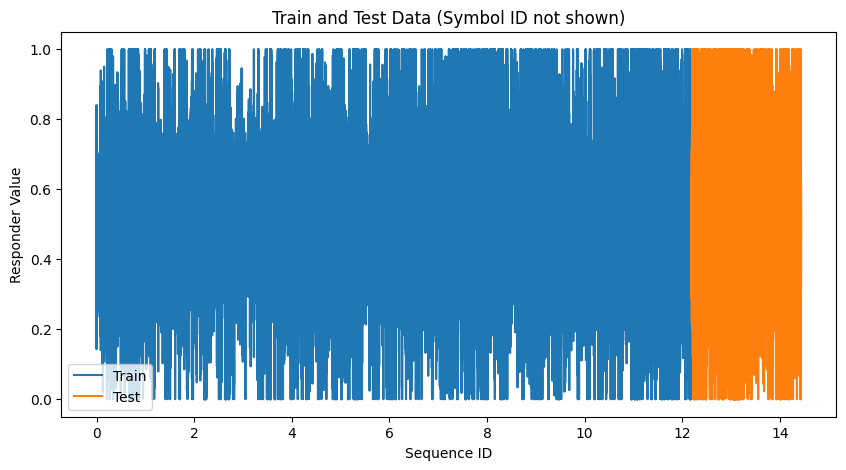

In [38]:
responder_i = train_data.dataset.columns.get_loc("responder_6")
seq_id_i = 0 # time-based sequence

# Access and plot data
fig = plt.figure(figsize=(10, 5))
_ = plt.title("Train and Test Data (Symbol ID not shown)")

_ = plt.plot(train_data.dataset.values[:,seq_id_i], train_data.dataset.values[:, responder_i])
_ = plt.plot(test_data.dataset.values[:,seq_id_i], test_data.dataset.values[:, responder_i])

_ = plt.legend(["Train", "Test"])
_ = plt.xlabel("Sequence ID")
_ = plt.ylabel("Responder Value")

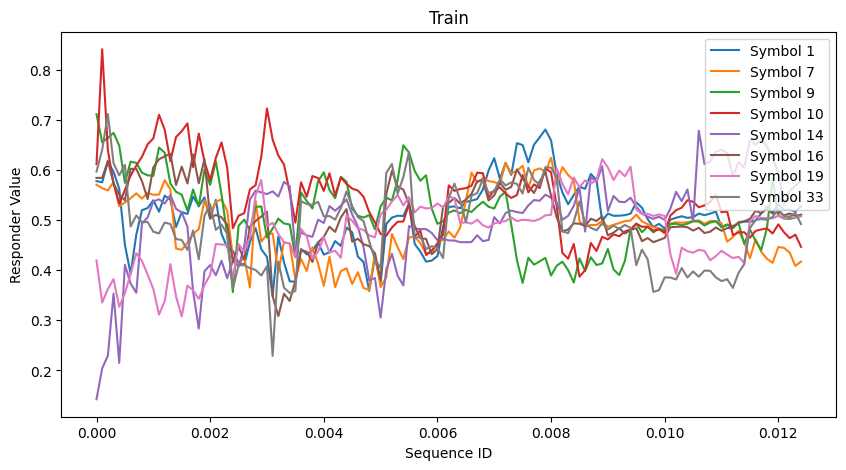

In [39]:
responder_i = train_data.dataset.columns.get_loc("responder_6")
seq_id_i = 0 # time-based sequence
data_range = 1000

# Filter data to the desired range
subset_data = train_data.dataset.iloc[:data_range]

# Get unique symbol_ids
unique_symbols = subset_data['symbol_id'].unique()

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Train")
ax.set_xlabel("Sequence ID")
ax.set_ylabel("Responder Value")

# Loop through each symbol_id and plot
for symbol in unique_symbols:
    symbol_data = subset_data[subset_data['symbol_id'] == symbol]
    ax.plot(
        symbol_data.iloc[:, seq_id_i],  # x-axis
        symbol_data.iloc[:, responder_i],  # y-axis
        label=f'Symbol {symbol}'  # Label for the legend
    )

# Add legend
ax.legend()
plt.show()

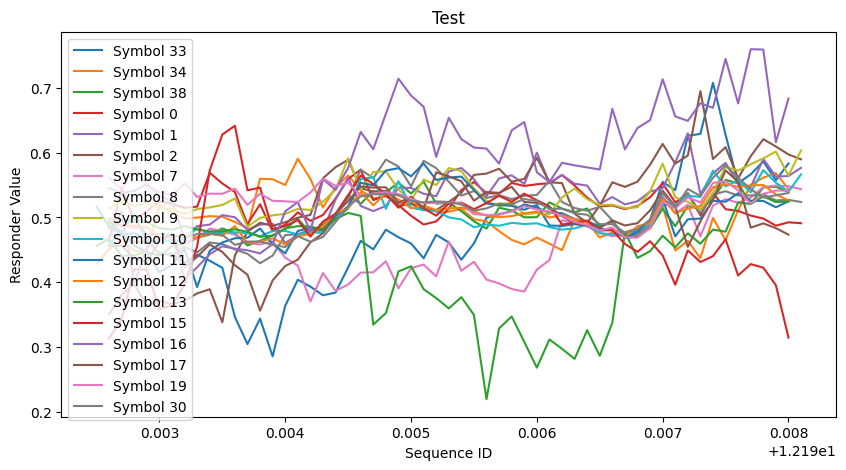

In [40]:
responder_i = train_data.dataset.columns.get_loc("responder_6")
seq_id_i = 0 # time-based sequence
data_range = 1000

# Filter data to the desired range
subset_data = test_data.dataset.iloc[:data_range]

# Get unique symbol_ids
unique_symbols = subset_data['symbol_id'].unique()

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Test")
ax.set_xlabel("Sequence ID")
ax.set_ylabel("Responder Value")

# Loop through each symbol_id and plot
for symbol in unique_symbols:
    symbol_data = subset_data[subset_data['symbol_id'] == symbol]
    ax.plot(
        symbol_data.iloc[:, seq_id_i],  # x-axis
        symbol_data.iloc[:, responder_i],  # y-axis
        label=f'Symbol {symbol}'  # Label for the legend
    )

# Add legend
ax.legend()
plt.show()

In [41]:
# Convert to dataloaders
batch_size = 32  # Batch size for training
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

## Set up model
- Changed from RNN class: buff args replaced with hidden and memory args
- TODO: Tinker around with vertical stacking of layer blocks
- TODO: Tinker around to see if input size and out size ok always being 128
    - output_size currently not related to out size but rather the no. of responders
- TODO: Tinker around with hidden layer size (currently 4*seq_data_len)

In [42]:
# Define a residual MLP block (same as before)
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size // 2)
        self.norm2 = nn.LayerNorm(input_size // 2)
        self.fc2 = nn.Linear(input_size // 2, output_size)
        self.fc_skip = nn.Linear(input_size, output_size)
        self.act = nn.ELU()

    def forward(self, x):
        # overall structure: input -> norm -> act -> skip
        #                    input -> norm -> act -> fc1 -> norm -> act -> fc2
        #                    return skip + fc2
        x = self.act(self.norm1(x))
        skip = self.fc_skip(x)
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        return x + skip


class LSTM(nn.Module):
    def __init__(self, seq_len, no_cols, batch_size, no_symbols, seq_out_size, num_blocks=1, hidden_size = 128): # NOTE: removed buffer_size arg from RNN class
        super(LSTM, self).__init__()
        
        # calculate length of sequence data
        seq_data_len = seq_len*no_cols
        output_size = seq_out_size*no_symbols*batch_size
        

        # Same as with mlp before
        self.input_mlp = nn.Sequential(
            nn.Linear(seq_data_len, 4 * seq_data_len),
            nn.ELU(),  
            nn.Linear(4 * seq_data_len, hidden_size) 
        )

        # Define LSTM block
        self.lstm = nn.LSTM(input_size = hidden_size, hidden_size = hidden_size, num_layers = num_blocks) 

        blocks = [ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        self.fc_out = nn.Linear(hidden_size, output_size) # this is for output
        self.act = nn.ELU()

    def forward(self, input_seq, hidden_in, mem_in):
        print(f"starting mlp input shape: {input_seq.shape}")
        input_seq = input_seq.reshape(input_seq.shape[0], -1)
        print(f"after reshaping mlp input shape: {input_seq.shape}")
        input_vec = self.input_mlp(input_seq).unsqueeze(0)

        # Pass through LSTM
        print(f"Finished mlp; starting lstm input shape: {input_vec.shape}")
        output, (hidden_out, mem_out) = self.lstm(input_vec, (hidden_in, mem_in))

        # Pass LSTM output through residual blocks
        print(f"Finished LSTM; starting res_blocks input shape: {output.shape}")
        x = self.act(self.res_blocks(output)).squeeze(0)

        # Compute the final output
        print(f"Finished resblocks; starting fc_out input shape: {x.shape}")
        return self.fc_out(x), hidden_out, mem_out

In [43]:
len(train_data.dataset.columns)

13

In [44]:
# Device
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Create an instance of the ResMLP model
# - seq_len is the number of days the model takes as input (days_in)
# - output_size is the number of outputs the model predicts (2: Max Daily Temperature and Rainfall)
hidden_size = 128
num_blocks = 1
no_symbols = len(train_data.dataset['symbol_id'].unique())
stock_lstm = LSTM(seq_len=days_in, batch_size = batch_size, no_cols=len(train_data.dataset.columns), no_symbols = no_symbols, seq_out_size=1, hidden_size=hidden_size, num_blocks=num_blocks).to(device)

# Initialize the optimizer
learning_rate = 1e-4  # Learning rate for the optimizer
optimizer = optim.Adam(stock_lstm.parameters(), lr=learning_rate)

# Define the loss function
loss_fn = nn.MSELoss()

# Initialize a list to log the training loss over epochs
training_loss_logger = []

In [45]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in stock_lstm.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 6199864 (Approximately 6 Million) Parameters!


## Train/Eval functions
- TODO: try to remove seq_id from training so that model not trained on trend? see which is better

In [ ]:
nepochs = 1
# Iterate over the number of epochs
for epoch in trange(nepochs, desc="Epochs", leave=False):

    # Set the model to training mode
    stock_lstm.train()
    
    # Iterate over the training data loader
    for data_seq in tqdm(train_dataloader, desc="Training", leave=False):
        
        # Extract the initial sequence block to be used as input for the model
        seq_block = data_seq[:, :days_in].to(device)

        # Initialize hidden and memory states for the LSTM with zeros
        hidden = torch.zeros(num_blocks, seq_block.size(0), hidden_size).to(device)
        memory = torch.zeros(num_blocks, seq_block.size(0), hidden_size).to(device)
        
        # Initialize the loss for the current batch
        loss = 0
        
        # Iterate over the remaining sequence to predict the next day values
        for i in range(day_range - days_in): # number of days trying to predict            
            # Make predictions using the model
            data_pred, hidden, memory = stock_lstm(seq_block, hidden, memory) # output is [batch_size x no_symbols]
            
            # for predictions on other symbols (not the target sequence one), just use the exact pred so no backprop done
            target_seq_block = data_pred.clone().detach()
            symbols_lst = data_seq[:, 1]
            for i in range(len(symbols_lst)):
                    symbols_lst = [int(val) for val in data_seq[:, 1].tolist()]  # 2nd val is the symbol
                    real_vals = target_seq_block[i,symbols_lst]
            
            # Accumulate the loss for the current prediction
            loss += loss_fn(data_pred, target_seq_block)
            
            # Update the input sequence by removing the oldest date and adding the new prediction
            # Detach the new sequence to prevent backpropagation through the old sequence
            seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1).detach() # 1st arg: all seq except first value, 2nd arg: latest prediction, 3rd arg: 1st dim
                                                                                            # detach() is used to prevent gradients from being calculated on the new sequence
                                                                                            # don't want to back prop over time

        # Average the accumulated loss over the number of steps
        loss /= i + 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log the training loss for later analysis
        training_loss_logger.append(loss.item())

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/48602 [00:00<?, ?it/s]

starting mlp input shape: torch.Size([32, 89, 13])
after reshaping mlp input shape: torch.Size([32, 1157])
Finished mlp; starting lstm input shape: torch.Size([1, 32, 128])
Finished LSTM; starting res_blocks input shape: torch.Size([1, 32, 128])
Finished resblocks; starting fc_out input shape: torch.Size([32, 128])


IndexError: tensors used as indices must be long, int, byte or bool tensors

In [ ]:
for data_seq in tqdm(train_dataloader, desc="Training", leave=False):
    seq_block = data_seq[:, :days_in]
    data_seq = data_seq[:, days_in+0]
    print(seq_block.shape)
    print(data_seq.shape)

    symbols_lst = [int(val) for val in data_seq[:, 1].tolist()]  # 2nd val is the symbol
    print(symbols_lst)
    real_vals = target_seq_block[i,symbols_lst]
    print(real_vals)
    break

Training:   0%|          | 0/48602 [00:00<?, ?it/s]

torch.Size([32, 89, 13])
torch.Size([32, 13])
[7, 2, 1, 9, 8, 38, 10, 1, 17, 7, 14, 12, 12, 12, 15, 38, 38, 34, 12, 16, 33, 15, 16, 7, 19, 8, 7, 33, 19, 13, 9, 17]
tensor([-0.0472, -0.1012, -0.0057, -0.5490, -0.4005, -0.2781, -0.6365, -0.0057,
         0.3425, -0.0472,  0.0937, -0.1501, -0.1501, -0.1501, -0.1107, -0.2781,
        -0.2781,  0.1666, -0.1501, -0.1780, -0.0063, -0.1107, -0.1780, -0.0472,
         0.2293, -0.4005, -0.0472, -0.0063,  0.2293,  0.5423, -0.5490,  0.3425])


## Train model
- Set parameters for training

In [ ]:
# Plot train loss over unique id (time-related axis)

## Evaluate Test and Plot